In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, Add, Dot, Conv2DTranspose, Activation, Reshape, LeakyReLU, Flatten, BatchNormalization, Lambda, Softmax, Concatenate
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils.generic_utils import Progbar
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from time import time
import os
import functools
import numpy as np
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from tensorflow.python.ops import array_ops
from skimage.transform import resize
from keras.models import load_model

Using TensorFlow backend.


In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

Load data sets

In [3]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Hyperparameters

In [4]:
#Hyperperemeter
BATCHSIZE=64
FID_BATCH_SIZE=64
LEARNING_RATE = 0.00002
TRAINING_RATIO = 1
BETA_1 = 0
BETA_2 = 0.9
EPOCHS = 700
BN_MIMENTUM = 0.1
BN_EPSILON  = 0.0002
fid_eval_steps = 1000
model_save_interval = 1

Directories to save losses, models and images

In [5]:
SAVE_IMG_DIR = "C:\\Users\\parit\\Documents\\testDCGAN\\img\\"
SAVE_LOGS_DIR = "C:\\Users\\parit\\Documents\\testDCGAN\\logs\\"
SAVE_LOSS_FID_LOGS = "C:\\Users\\parit\\Documents\\testDCGAN\\fid_logs\\"
model_save_dir = "C:\\Users\\parit\\Documents\\testDCGAN\\models\\"

Generator Model

In [6]:
 def BuildGenerator(): 
    noise = Input(shape=(128,))
    net = Dense(4*4*512, kernel_initializer='glorot_uniform')(noise)
    net = Reshape((4,4,512))(net)
    net = Conv2DTranspose(256, kernel_size=4, strides=2, padding='same', kernel_initializer='glorot_uniform', activation = 'relu')(net)
    net = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM)(net)
    net = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', kernel_initializer='glorot_uniform',activation = 'relu')(net)
    net = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM)(net)
    net = Conv2DTranspose(64,  kernel_size=4, strides=2, padding='same', kernel_initializer='glorot_uniform',activation = 'relu')(net)
    net = BatchNormalization(epsilon=BN_EPSILON, momentum=BN_MIMENTUM)(net)
    op = Conv2DTranspose(3,   kernel_size=3, strides=1, padding='same', activation='tanh')(net)
    model = Model(noise, op)
    model.summary()
    return model

Discriminator Model

In [7]:
def BuildDiscriminator():

    img = Input(shape=(32,32,3))
    net = Conv2D(64, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same')(img)
    net = LeakyReLU(0.1)(net)
    net = Conv2D(64, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same')(net)
    net = LeakyReLU(0.1)(net)
    net = Conv2D(128, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same')(net)
    net = LeakyReLU(0.1)(net)
    net = Conv2D(128, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same')(net)
    net = LeakyReLU(0.1)(net)
    net = Conv2D(256, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same')(net)
    net = LeakyReLU(0.1)(net)
    net = Conv2D(256, kernel_size=4, strides=2,kernel_initializer='glorot_uniform', padding='same')(net)
    net = LeakyReLU(0.1)(net)
    net = Conv2D(512, kernel_size=3, strides=1,kernel_initializer='glorot_uniform', padding='same')(net)
    net = LeakyReLU(0.1)(net)
    net = Flatten()(net)
    op  = Dense(1,kernel_initializer='glorot_uniform', activation = 'sigmoid')(net)
    model = Model(img, op)
    model.summary()
    return model

Gan Model

In [8]:
def Buildgan(generator, discriminator):
    Noise_input                        = generator.input
    Generated_image                    = generator(Noise_input)
    Discriminator_output               = discriminator(Generated_image)
    gan                                = Model(Noise_input, Discriminator_output)
    return gan

Build all models

In [9]:
generator = BuildGenerator()
discriminator = BuildDiscriminator()
gan = Buildgan(generator, discriminator)







_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         2097408   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       524416    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       
____

Load weights for training continuation from previous point

In [10]:
generator.load_weights("DCGAN_generator_model_weights.h5")
discriminator.load_weights("DCGAN_discriminator_model_weights.h5")
gan.load_weights("DCGAN_gan_model_weights.h5")

Compile Models

In [11]:
print("model_for_training_discriminator")
discriminator.trainable = True
discriminator.compile(optimizer=Adam(LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2), loss='binary_crossentropy')
discriminator.summary()
print("model_for_training_generator")
discriminator.trainable = False
generator.trainable = True
gan.compile(optimizer=Adam(LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2), loss='binary_crossentropy')
gan.summary()

model_for_training_discriminator

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        65600     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
______________

In [12]:
real_y = np.ones((BATCHSIZE, 1), dtype=np.float32)
fake_y = np.zeros((BATCHSIZE, 1), dtype=np.float32)
X = x_train
X = X/255*2-1

FID related Functions. Calculate mean and variance of validated image datasets.

In [13]:
inception = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)

def inception_activations(images):
    size = 299
    images = images.astype('float32')
    images = scale_images(images, (299,299,3))
    images = preprocess_input(images)
    activations = inception.predict(images)
    return activations
## Batched FID because of my memory constraints
def get_inception_activations(inps):
    n_batches = int(np.ceil(float(inps.shape[0]) / FID_BATCH_SIZE))
    act = np.zeros([inps.shape[0], 2048], dtype = np.float32)
    for i in range(n_batches):
        inp = inps[i * FID_BATCH_SIZE : (i + 1) * FID_BATCH_SIZE]
        act[i * FID_BATCH_SIZE : i * FID_BATCH_SIZE + min(FID_BATCH_SIZE, inp.shape[0])] = inception_activations(inp)
    return act

#Compute validation image dataset statistics
f1 = get_inception_activations(x_test)
mean1, sigma1 = f1.mean(axis=0), np.cov(f1, rowvar=False)

Savemodel functions

In [14]:
def save_models(generator, discriminator, gan, epoch_no, model_save_dir = model_save_dir):
        discriminator.trainable = True
        save_model(discriminator, model_save_dir + 'discriminator_model', epoch_no)
        generator.trainable = True
        save_model(generator, model_save_dir + 'generator_model', epoch_no)
        discriminator.trainable = False
        save_model(gan, model_save_dir + 'gan_model', epoch_no)
        
def save_model(model, model_path, epoch_no):
        with open(str(model_path) + '_' + str(epoch_no) + '.json', 'w') as json_file:
            json_file.write(model.to_json())

        with open(str(model_path) + '.json', 'w') as json_file:
            json_file.write(model.to_json())
            
        model.save_weights(str(model_path + '_' + "weights_" + str(epoch_no) + '.h5'))
        model.save_weights(str(model_path + '_' + "weights" + '.h5'))
        
        model.save(str(model_path+ '.h5'))  # creates a HDF5 file 'my_model.h5'

Plot Functions

In [15]:
def save_plot(images, epoch, path, n=10):
    fig = plt.figure(figsize=(5,5))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.01, wspace=0.01)
    for i in range(100):
        ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(images[i], cmap='gray')
    plt.savefig(path+'DCGAN_{:05d}.png'.format(epoch))
    plt.close()
    
def plot_images(x, imgsize, batch_size=100):
    fig = plt.figure(figsize=(imgsize,imgsize))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.01, wspace=0.01)

    for i in range(batch_size):
        ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(x[i], cmap='gray')

Run this cell only for training

In [ ]:
img_gen_noise = np.random.randn(100, 128)

D_real = []
D_fake = []
D_loss = []
G_loss = []

d_real_perepoch = []
d_fake_perepoch = []
d_loss_perepoch = []
g_loss_perepoch = []

FID = []
fid = 0
counter = 0
true_label = y_train
for epoch in range(EPOCHS):
    np.random.shuffle(X)
    print("epoch {} of {}".format(epoch+1, EPOCHS))
    num_batches = int(X.shape[0] // BATCHSIZE)
    
    print("number of batches: {}".format(int(X.shape[0] // (BATCHSIZE))))
    
    progress_bar = Progbar(target=int(X.shape[0] // (BATCHSIZE)), width=20)
    minibatches_size = BATCHSIZE 
    start_time = time()
    for index in range(int(X.shape[0] // (BATCHSIZE ))):
        progress_bar.update(index)
        image_batch = X[index * BATCHSIZE : (index + 1) * BATCHSIZE]
        noise = np.random.randn(BATCHSIZE, 128).astype(np.float32)
        
        ## Train Dicriminator
        discriminator.trainable = True
        generator.trainable = False
        generated_image = generator.predict(noise)
        # print(generated_image.shape)
        err_real = discriminator.train_on_batch(image_batch, real_y)
        err_fake = discriminator.train_on_batch(generated_image, fake_y)
        err_total = 0.5*(err_real + err_fake)
        D_loss.append(err_total)
        D_real.append(err_real)
        D_fake.append(err_fake)
        
        ## Train Generator
        discriminator.trainable = False
        generator.trainable = True
        err_g = gan.train_on_batch(np.random.randn(BATCHSIZE, 128), real_y)
        G_loss.append(err_g)
        with open(SAVE_LOSS_FID_LOGS + "logs" + ".txt", "a") as f:
            f.write((str(err_real) + '\t' + str(err_fake) + '\t' + str(err_total) + '\t' + str(err_g) + '\n'))
        counter +=1
        
        
        ## FID Calculation taking 10000 images
        if(np.mod(counter, fid_eval_steps) == 0):
            samples = np.zeros((10000, 32, 32, 3))
            n_batches = 20
            lo = 0
            for btch in range(n_batches):
                
                sample_fid = np.random.randn(500, 128)
                samples[lo:(lo+500)] = generator.predict(sample_fid)
                lo += 500
            samples = (samples + 1.) * 127.5            
            f2 = get_inception_activations(samples)
            mean2, sigma2 = f2.mean(axis=0), np.cov(f2, rowvar=False)
            sum_sq_diff = np.sum((mean1 - mean2)**2)
            cov_mean = sqrtm(sigma1.dot(sigma2))
            if np.iscomplexobj(cov_mean):
                cov_mean = cov_mean.real
            fid = sum_sq_diff + np.trace(sigma1 + sigma2 - 2.0*cov_mean)
            
            FID.append(fid)
            with open(SAVE_LOSS_FID_LOGS + "logs" + ".txt", "a") as f:
                f.write(str(err_real) + '\t' + str(err_fake) + '\t' + str(err_total) + '\t' + str(err_g) + '\t' + str(fid) + '\n')

    if (epoch+1) % model_save_interval == 0:
        save_models(generator, discriminator, gan, epoch)
    
    print('\nepoch time: {}'.format(time()-start_time))
    print("fid: {}".format(fid))
    d_real_perepoch.append(err_real)
    d_fake_perepoch.append(err_fake)
    d_loss_perepoch.append(err_total)
    g_loss_perepoch.append(err_g)

    print("d_real_loss:{} d_fake_loss:{} d_loss:{} g_loss:{}".format(d_real_perepoch[-1], d_fake_perepoch[-1], d_loss_perepoch[-1], g_loss_perepoch[-1]))
        #Generate image
    generated_image = generator.predict(img_gen_noise)
    generated_image = (generated_image + 1)/2
    save_plot(generated_image, epoch, SAVE_IMG_DIR, 10) 

Run This Cell for Testing

Calculating FID
FID: 55.662306143469365


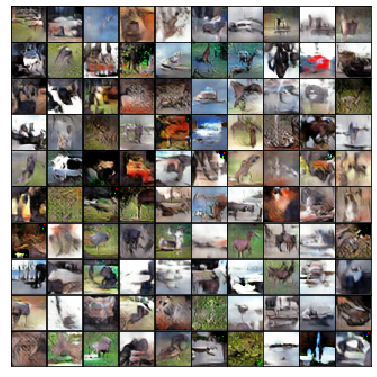

In [21]:
weightspath = "DCGAN_generator_model_weights.h5"
generator.load_weights(weightspath)
img_gen_noise = np.random.randn(100, 128)
generated_image = generator.predict(img_gen_noise)
generated_image = (generated_image + 1)/2
plot_images(generated_image, 5, 100)

print("Calculating FID")
samples = np.zeros((10000, 32, 32, 3))
n_batches = 20   ## 10000/500
lo = 0
for btch in range(n_batches):
    sample_fid = np.random.randn(500, 128)
    samples[lo:(lo+500)] = generator.predict(sample_fid)
    lo += 500
samples = (samples + 1.) * 127.5            
f2 = get_inception_activations(samples)
mean2, sigma2 = f2.mean(axis=0), np.cov(f2, rowvar=False)
sum_sq_diff = np.sum((mean1 - mean2)**2)
cov_mean = sqrtm(sigma1.dot(sigma2))
if np.iscomplexobj(cov_mean):
    cov_mean = cov_mean.real
fid = sum_sq_diff + np.trace(sigma1 + sigma2 - 2.0*cov_mean)
print("FID: {}".format(fid))